In [133]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

In [134]:
train_df = pd.read_csv('../input/train.csv', index_col='Id')
test_df = pd.read_csv('../input/test.csv', index_col='Id')

In [135]:
train_df.info()
print('------------------------------')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

In [136]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [138]:
test_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


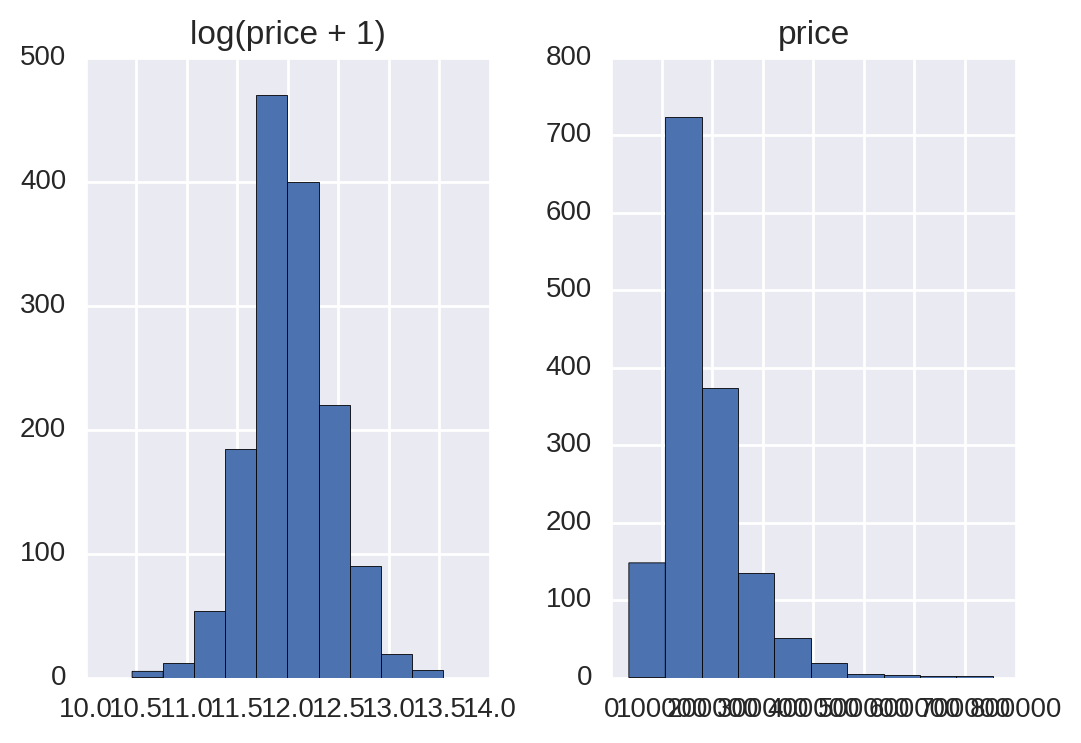

In [139]:
import matplotlib
plt.figure(figsize=(3, 18))
prices = pd.DataFrame({"price":train_df["SalePrice"], "log(price + 1)":np.log1p(train_df["SalePrice"])})
prices.hist()
target = np.log1p(prices.price)

In [140]:
concat = pd.concat([train_df.drop(['SalePrice'], axis=1), test_df])

In [141]:
numFeat = concat.dtypes[concat.dtypes != object].index
strFeat = concat.dtypes[concat.dtypes == object].index
floatFeat = concat.dtypes[concat.dtypes == float].index
concat[strFeat] = concat[strFeat].fillna('NA')

In [142]:
concat[floatFeat].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 11 columns):
LotFrontage     2433 non-null float64
MasVnrArea      2896 non-null float64
BsmtFinSF1      2918 non-null float64
BsmtFinSF2      2918 non-null float64
BsmtUnfSF       2918 non-null float64
TotalBsmtSF     2918 non-null float64
BsmtFullBath    2917 non-null float64
BsmtHalfBath    2917 non-null float64
GarageYrBlt     2760 non-null float64
GarageCars      2918 non-null float64
GarageArea      2918 non-null float64
dtypes: float64(11)
memory usage: 273.7 KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb682372bd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb681e20690>]], dtype=object)

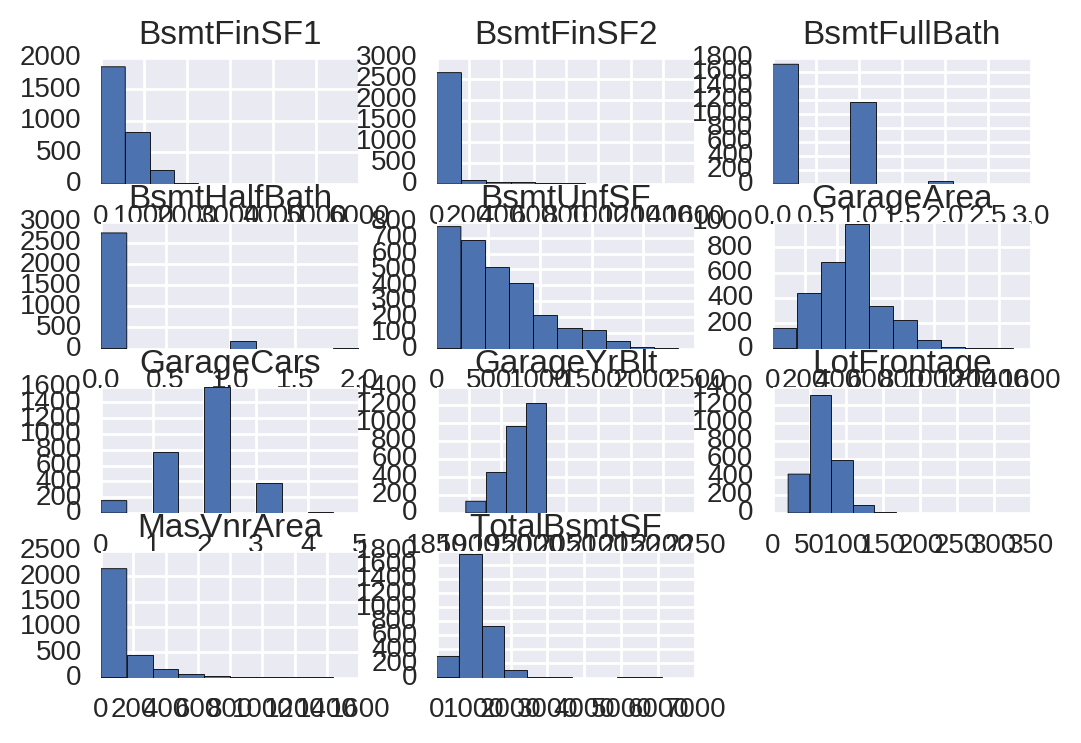

In [143]:
concat[floatFeat].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb681c8dc10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb681629f10>]], dtype=object)

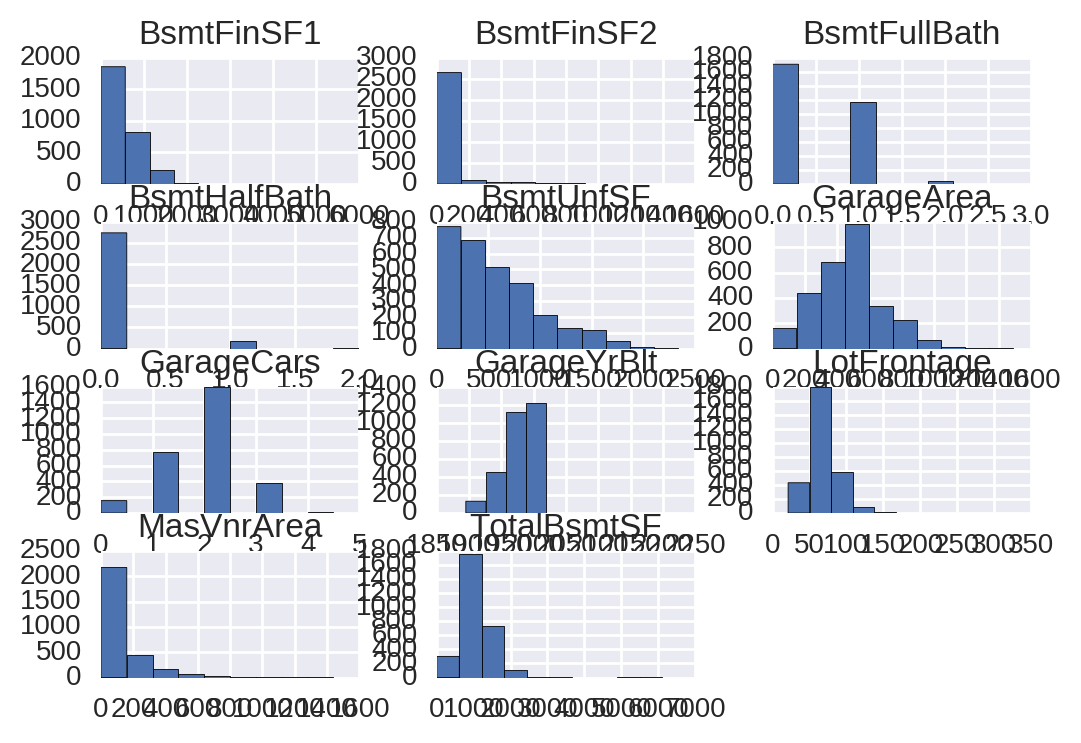

In [144]:
concat[floatFeat].fillna(concat[floatFeat].mean()).hist()

In [145]:
concat[floatFeat] = concat[floatFeat].fillna(concat[floatFeat].mean())

In [146]:
concat[numFeat] = concat[numFeat].astype(float)

In [147]:
concat = concat.join(pd.get_dummies(concat[strFeat]))

In [148]:
concat.drop(strFeat, inplace=True, axis=1)

In [149]:
from sklearn.preprocessing import StandardScaler

In [150]:
train_df = concat[:train_df.shape[0]]
test_df = concat[train_df.shape[0]:]

In [151]:
prices

,log(price + 1),price
Id,,
1,12.247699,208500
2,12.109016,181500
3,12.317171,223500
4,11.849405,140000
5,12.429220,250000
6,11.870607,143000
7,12.634606,307000
8,12.206078,200000
9,11.774528,129900


In [156]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_df.values, target, test_size=0.33, random_state=42)

In [162]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=1500, n_jobs=7)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1500, n_jobs=7, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [166]:
pred = model.predict(X_test)
np.sqrt(mean_squared_error(y_test, pred))

0.14476984705009568

In [225]:
importance = pd.Series(model.feature_importances_, index=train_df.columns).sort_values(ascending=False)
bestFeat = importance[importance > 1e-3].index

In [229]:
from sklearn.cross_validation import cross_val_score
rf = RandomForestRegressor(n_estimators=1000)
#rf.fit(train_df[bestFeat].values, target)

In [168]:
def rmse(model):
    return np.sqrt(-cross_val_score(model, train_df.values, y=target, scoring='mean_squared_error'))

In [230]:
rmse(rf)

array([ 0.14096159,  0.15604146,  0.14027361])

In [228]:
pd.DataFrame([np.log1p(pred), y_test])

,0,1,2,3,4,5,6,7,8,9,...,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458
0,11.744780,11.940245,12.131479,12.125809,12.204338,12.110871,12.019548,12.054096,12.112225,11.668056,...,11.301101,11.392385,11.931243,11.427564,11.375778,11.380405,11.396259,11.973375,11.641697,12.351609
1,11.947956,12.691584,11.652696,11.976666,12.661917,11.231901,12.649158,11.891369,11.344519,11.816734,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [191]:
rmse(rf)

array([ 0.14168532,  0.1558891 ,  0.14050501])

In [196]:
from scipy.stats import pearsonr
pearson = train_df[numFeat].apply(lambda x : pearsonr(x.dropna(), target.ix[x.notnull()])[0])
pearson.sort_values(ascending=False)

OverallQual      0.817185
GrLivArea        0.700927
GarageCars       0.680625
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
TotRmsAbvGrd     0.534422
GarageYrBlt      0.501656
Fireplaces       0.489450
MasVnrArea       0.429498
BsmtFinSF1       0.372023
LotFrontage      0.335555
WoodDeckSF       0.334135
OpenPorchSF      0.321053
2ndFlrSF         0.319300
HalfBath         0.313982
LotArea          0.257320
BsmtFullBath     0.236224
BsmtUnfSF        0.221985
BedroomAbvGr     0.209043
ScreenPorch      0.121208
PoolArea         0.069798
MoSold           0.057330
3SsnPorch        0.054900
BsmtFinSF2       0.004832
BsmtHalfBath    -0.005149
MiscVal         -0.020021
OverallCond     -0.036868
YrSold          -0.037263
LowQualFinSF    -0.037963
MSSubClass      -0.073959
KitchenAbvGr    -0.147548
EnclosedPorch   -0.149050
dtype: float64

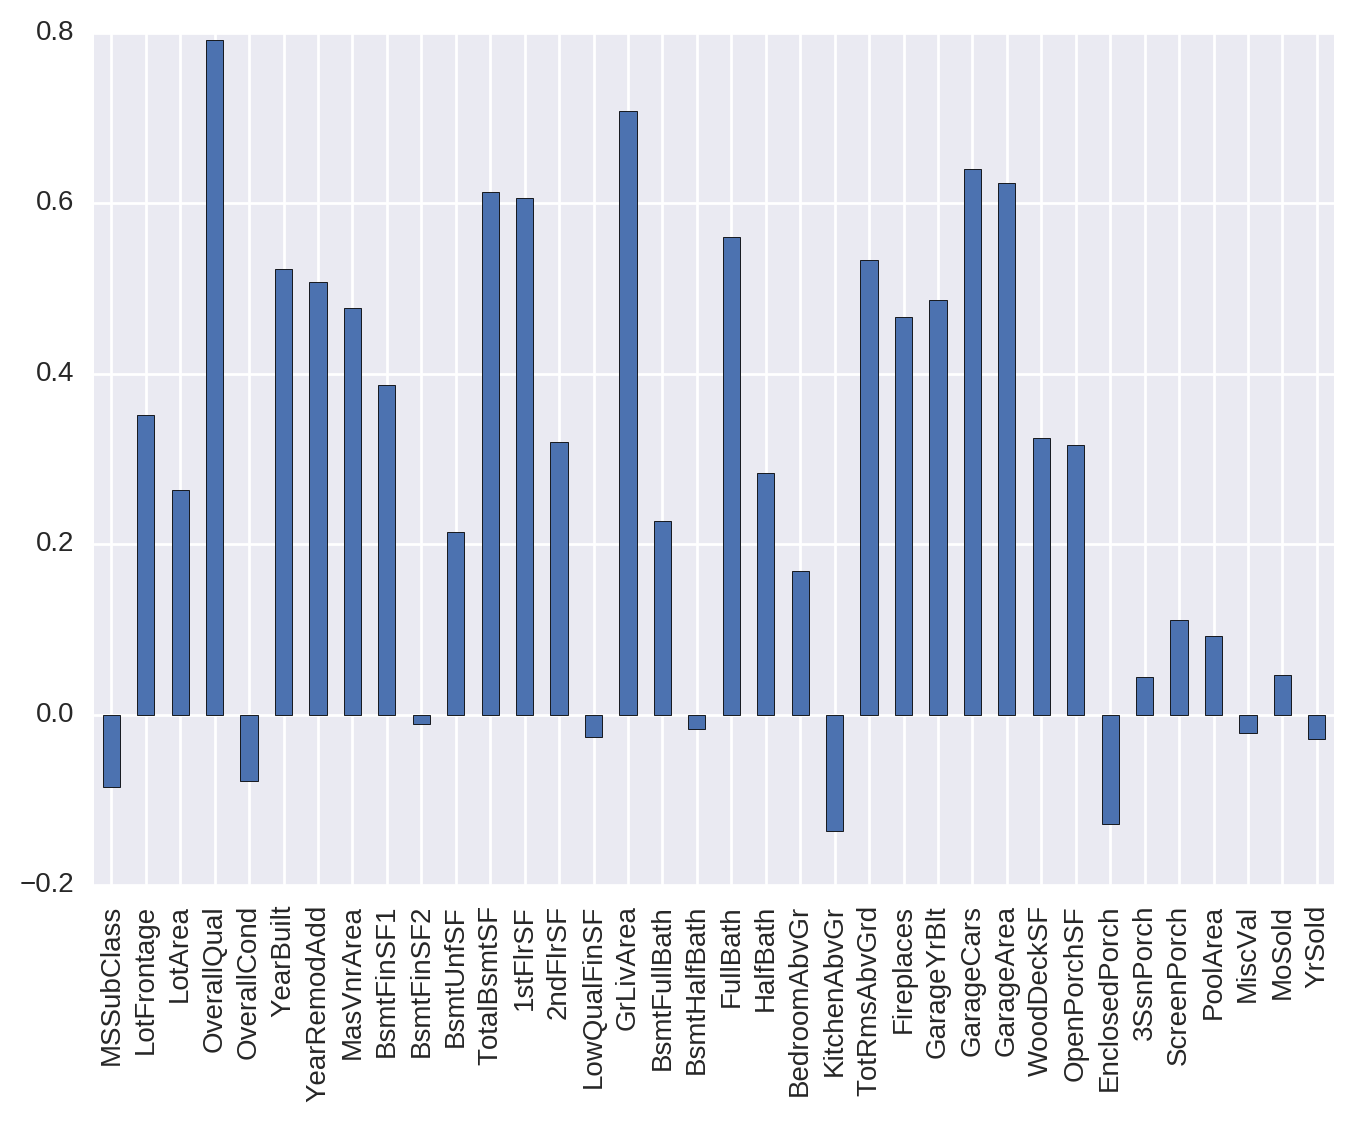

In [103]:
pearson.plot(kind='bar')

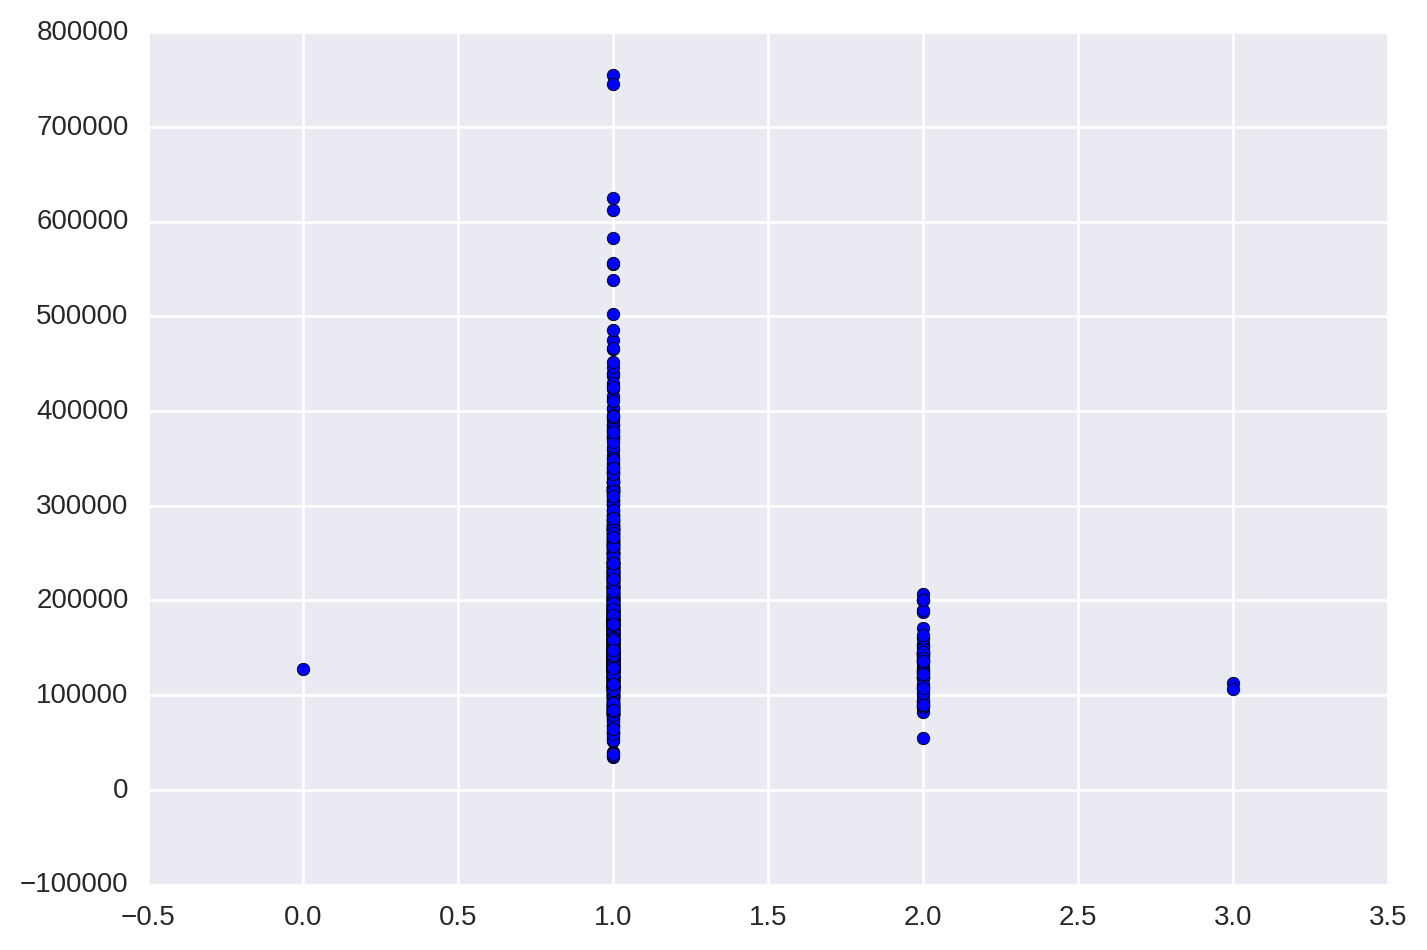

In [85]:
plt.scatter(train_df.KitchenAbvGr, train_df.SalePrice)

In [189]:
y_pred = np.expm1(rf.predict(test_df.values))

In [190]:
output('../output/rf1000.csv')

In [183]:
def output(path):
    out_df = pd.DataFrame(y_pred, index=test_df.index, columns=['SalePrice'])
    out_df.to_csv(path)

In [64]:
train_df[floatFeat].apply(lambda x : pearsonr(x.dropna(), train_df.SalePrice.ix[x.notnull()]))

LotFrontage      (0.351799096571, 2.60244181239e-36)
MasVnrArea       (0.477493047096, 1.45850864259e-83)
BsmtFinSF1       (0.386419806242, 3.39410982929e-53)
BsmtFinSF2        (-0.0113781214502, 0.663998650834)
BsmtUnfSF        (0.214479105547, 1.18297579636e-16)
TotalBsmtSF      (0.613580551559, 9.4842293915e-152)
BsmtFullBath     (0.227122233131, 1.55034413721e-18)
BsmtHalfBath      (-0.0168441542974, 0.520153635728)
GarageYrBlt      (0.486361677488, 8.70512794214e-83)
GarageCars      (0.640409197258, 2.49864416718e-169)
GarageArea      (0.623431438918, 5.26503816798e-158)
dtype: object

In [105]:
train_df.dtypes[train_df.dtypes == float]

LotFrontage    float64
MasVnrArea     float64
GarageYrBlt    float64
dtype: object

In [106]:
concat.dtypes[concat.dtypes == float]

LotFrontage     float64
MasVnrArea      float64
BsmtFinSF1      float64
BsmtFinSF2      float64
BsmtUnfSF       float64
TotalBsmtSF     float64
BsmtFullBath    float64
BsmtHalfBath    float64
GarageYrBlt     float64
GarageCars      float64
GarageArea      float64
dtype: object

In [118]:
type(train_df.LotFrontage[8])

numpy.float64

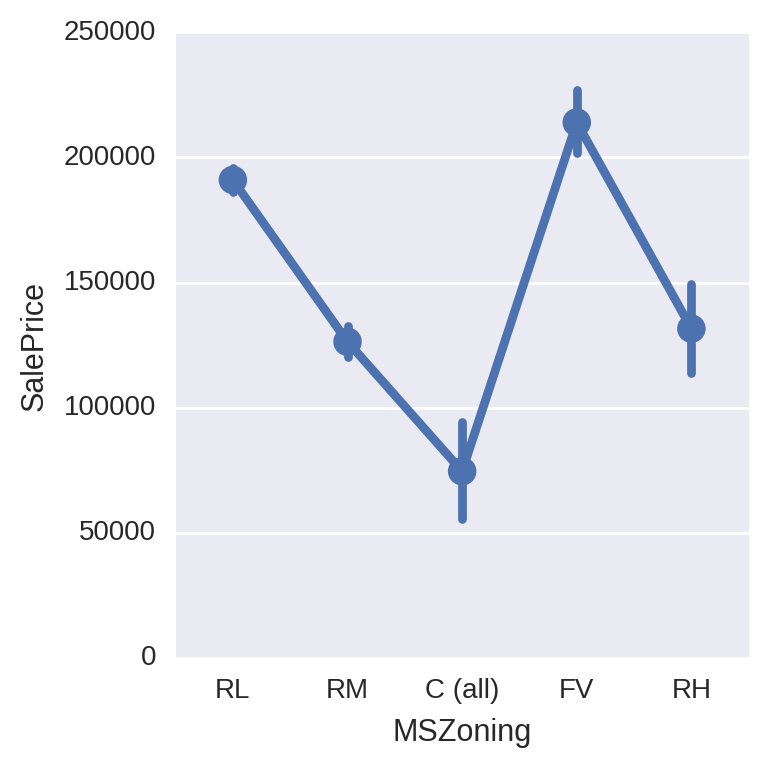

In [121]:
sns.factorplot(x='MSZoning', y='SalePrice', data=train_df)

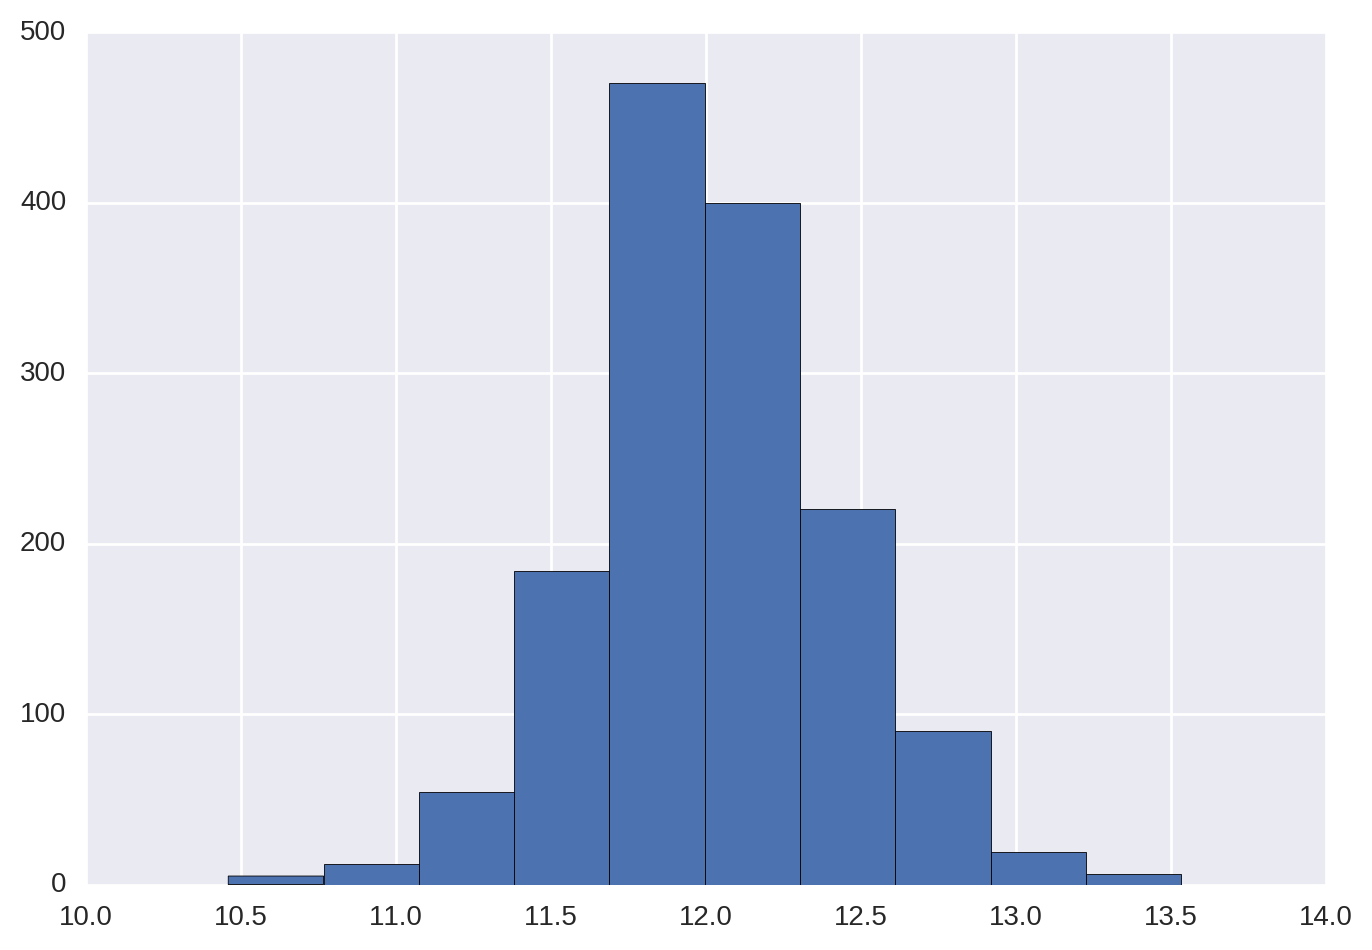

In [11]:
np.log1p(train_df.SalePrice).hist()